# 任务五：基于神经网络的语言模型
### 用LSTM、GRU来训练字符级的语言模型，计算困惑度

参数设置：

训练集：poetryFromTang.txt
模型：LSTM / GRU
词嵌入：Random Embedding

random_seed：2024
学习率：0.004
batch_size：1
embedding_size：50  # 每个词向量有几维
hidden_size：50
iter_times：250


### 1. 语言模型：LSTM/GRU

In [21]:
import torch.nn as nn
import torch
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
"""语言模型：LSTM/GRU"""
class Language(nn.Module):
    def __init__(self, len_feature, len_words, len_hidden, num_to_word, word_to_num, strategy='LSTM', pad_id=0, start_id=1, end_id=2, drop_out=0.5):
        super(Language, self).__init__()
        self.pad_id = pad_id
        self.start_id=start_id
        self.end_id = end_id
        # 一个将数字编码转换为单词的字典
        self.num_to_word = num_to_word
        # 一个将单词转换为数字编码的字典
        self.word_to_num = word_to_num
        self.len_feature = len_feature
        self.len_words = len_words
        self.len_hidden = len_hidden
        self.dropout = nn.Dropout(drop_out)
        _x = nn.init.xavier_normal_(torch.Tensor(len_words, len_feature))
        self.embedding = nn.Embedding(num_embeddings=len_words, embedding_dim=len_feature, _weight=_x)
        if strategy == 'LSTM':
            self.gate = nn.LSTM(input_size=len_feature, hidden_size=len_hidden, batch_first=True)
        elif strategy == 'GRU':
            self.gate = nn.GRU(input_size=len_feature, hidden_size=len_hidden, batch_first=True)
        else:
            raise Exception("Unknown Strategy!")
        # 全连接层对象，该层将从LSTM/GRU中获得的隐藏状态转换为输出单词的概率。
        self.fc = nn.Linear(len_hidden, len_words)
    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        self.gate.flatten_parameters()
        # gate表示门控循环单元（GRU）或长短时记忆（LSTM）单元
        x, _ = self.gate(x)
        # fc线性变换，返回预测结果的概率分布logits
        logits = self.fc(x)
        return logits
 
 
    """ 生成固定古诗 """
    # max_len 每行诗句的最大长度；num_sentence 生成古诗的行数
    def generate_random_poem(self, max_len, num_sentence, random=False):
        if random:
          initialize = torch.randn
        else:
          initialize = torch.zeros
        # 初始化隐藏状态 hn 和细胞状态 cn
        hn = initialize((1, 1, self.len_hidden)).to(device)
        cn = initialize((1, 1, self.len_hidden)).to(device)
        # 使用诗歌开始标记的 ID 初始化当前的输入 x，同时创建一个空列表 poem，用于保存生成的古诗
        x = torch.LongTensor([self.start_id]).to(device)
        poem = list()
        # 循环生成古诗，直到达到指定的行数
        while(len(poem)!=num_sentence):
            word = x
            sentence = list()
            for j in range(max_len):
                # 每次生成一个词。首先将当前的输入 word 转换为张量
                word = torch.LongTensor([word]).to(device)
                word = self.embedding(word).view(1, 1, -1)
                output, (hn, cn) = self.gate(word, (hn, cn))
                output = self.fc(output)
                # 获取概率最大的词的 ID
                word = output.topk(1)[1][0].item()
                """
                如果生成的词是句子结束标记的ID，则将当前输入 x 设置为诗歌开始标记的ID，并跳出内层循环。
                如果生成的词不是句子结束标记，则将其对应的词语添加到当前句子 sentence 中。
                如果生成的词是句号 self.word_to_num['。'] 的 ID，则说明当前诗句已经结束，跳出内层循环。
                """
                if word == self.end_id:
                    x = torch.LongTensor([self.start_id]).to(device)
                    break
                sentence.append(self.num_to_word[word])
                if self.word_to_num['。'] == word:
                  break
            # 如果内层循环正常结束，则说明当前诗句已经达到了最大长度 max_len，此时将当前输入 x 设置为句号的 ID 。
            else:
              x = self.word_to_num['。']
            # 如果当前诗句非空，则将其添加到生成的古诗列表 poem 中。
            if sentence:
              poem.append(sentence)
        #print(self.word_to_num.items())
        return poem
 
 
    """生成藏头诗句"""
    def generate_hidden_head(self, heads, max_len=50, random=False):  # head是藏头诗的每一行的开头的字；max_len表示每一行最多包含的字数
        # 循环遍历输入的每一个开头的字
        for head in heads:
            if head not in self.word_to_num:
                raise Exception("Word: "+head+" is not in the dictionary, please try another word")
        poem = list()
        if random:
          initialize = torch.randn
        else:
          initialize = torch.zeros
        # 生成每一行的藏头诗
        for i in range(len(heads)):
            # 获取开头字 heads[i] 对应的数字 word，并将其作为起始字符
            word = self.word_to_num[heads[i]]
            sentence = [heads[i]]
            hn = initialize((1, 1, self.len_hidden)).to(device)
            cn = initialize((1, 1, self.len_hidden)).to(device)
            for j in range(max_len-1):
                word = torch.LongTensor([word]).to(device)
                word = self.embedding(word).view(1, 1, -1)
                output, (hn, cn) = self.gate(word, (hn, cn))
                # 下一个字的概率分布
                output = self.fc(output)
                # 根据上述分布采样得到下一个字的数字 word
                word = output.topk(1)[1][0].item()
                # 将当前字符添加到句子末尾，如果当前字符是句号，则停止生成这一行。
                sentence.append(self.num_to_word[word])
                if self.word_to_num['。'] == word:
                  break
            # 生成完一行之后，将其添加到 poem 列表中
            poem.append(sentence)
        return poem

### 2. 特征提取

In [22]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn.utils.rnn import pad_sequence
 
 
""" 词嵌入模型 """
class Random_Embedding():
    def __init__(self, data):
        self.data = data
        # 将每个汉字映射到一个唯一的整数 ID
        self.word_dict = {'<pad>': 0, '<begin>': 1, '<end>': 2}
        # 将每个 ID 映射回对应的汉字
        self.tag_dict = {0: '<pad>', 1: '<begin>', 2: '<end>'}
        self.matrix = list()
 
    # 诗歌分割
    def form_poem(self):
        # 将每个元素转换为utf-8的编码
        data_utf8 = list(map(lambda x, y: str(x, encoding=y), self.data, ['utf-8'] * len(self.data)))
        poems = list()
        # 将每首诗歌定义为一个字符串，包含一个诗歌的所有行
        new_poem = ""
        for item in data_utf8:
            # 如果当前元素是一个换行符，则表示我们已经到了当前诗歌的结尾
            if item == '\n':
                if new_poem:
                    poems.append(new_poem)
                new_poem = ""
            else:
                # 如果当前元素不是换行符，则表示我们需要将其添加到当前诗歌中
                if item[-2] == ' ':
                  position = -2
                else:
                  position = -1
                new_poem = ''.join([new_poem, item[:position]])
        self.data = poems
        print(self.data)
 
    def get_words(self):
        for poem in self.data:
            for word in poem:
                if word not in self.word_dict:
                    self.tag_dict[len(self.word_dict)]=word
                    self.word_dict[word] = len(self.word_dict)
 
    def get_id(self):
        for poem in self.data:
            # 将每一首诗转换为一个由词的ID号组成的列表
            self.matrix.append([self.word_dict[word] for word in poem])
 
    def data_process(self):
        self.form_poem()
        # 按照长度进行升序排序
        self.data.sort(key=lambda x: len(x))
        self.get_words()
        self.get_id()
 
 
""" 加载和预处理输入数据 """
class ClsDataset(Dataset):
    def __init__(self, poem):
        self.poem = poem
    def __getitem__(self, item):
        return self.poem[item]
    def __len__(self):
        return len(self.poem)
 
 
""" 自定义batch数据的输出形式 """
# 函数 collate_fn是 PyTorch 中 DataLoader 类的一个参数，用于在迭代数据时组合数据样本
# 将一个 batch 中的数据样本按照句子长度进行填充，以便构造成一个张量
def collate_fn(batch_data):
    poems = batch_data
    # 在每首诗歌的开头添加一个特殊的标记begin
    poems = [torch.LongTensor([1, *poem]) for poem in poems]
    padded_poems = pad_sequence(poems, batch_first=True, padding_value=0)
    # 在每首诗歌的末尾添加一个特殊的标记end
    padded_poems = [torch.cat([poem, torch.LongTensor([2])]) for poem in padded_poems]
    padded_poems = list(map(list, padded_poems))
    return torch.LongTensor(padded_poems)
 
# 使用自定义数据集，通过 dataloader 可以实现对整个数据集的批量迭代
def get_batch(x, batch_size):
    dataset = ClsDataset(x)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True, collate_fn=collate_fn)
    return dataloader

### 3. 主程序

['巴山上峡重复重，阳台碧峭十二峰。荆王猎时逢暮雨，夜卧高丘梦神女。轻红流烟湿艳姿，行云飞去明星稀。目极魂断望不见，猿啼三声泪沾衣。', '见尽数万里，不闻三声猿。但飞萧萧雨，中有亭亭魂。千载楚襄恨，遗文宋玉言。至今青冥里，云结深闺门。', '碧丛丛，高插天，大江翻澜神曳烟。楚魂寻梦风飔然，晓风飞雨生苔钱。瑶姬一去一千年，丁香筇竹啼老猿。古祠近月蟾桂寒，椒花坠红湿云间。', '巫山高，巫女妖，雨为暮兮云为朝，楚王憔悴魂欲销。秋猿嗥嗥日将夕，红霞紫烟凝老壁。千岩万壑花皆坼，但恐芳菲无正色。不知今古行人行，几人经此无秋情。云深庙远不可觅，十二峰头插天碧。', '君不见黄河之水天上来，奔流到海不复回。君不见高堂明镜悲白发，朝如青丝暮成雪。人生得意须尽欢，莫使金尊空对月。天生我材必有用，千金散尽还复来。烹羊宰牛且为乐，会须一饮三百杯。岑夫子，丹丘生，将进酒，杯莫停。与君歌一曲，请君为我侧耳听。钟鼓馔玉不足贵，但愿长醉不复醒。古来圣贤皆寂寞，惟有饮者留其名。陈王昔时宴平乐，斗酒十千恣欢谑。主人何为言少钱，径须酤取对君酌。五花马，千金裘，呼儿将出换美酒，与尔同销万古愁。', '将进酒，将进酒，酒中有毒鸩主父，言之主父伤主母。母为妾地父妾天，仰天俯地不忍言。佯为僵踣主父前，主父不知加妾鞭。旁人知妾为主说，主将泪洗鞭头血。推摧主母牵下堂，扶妾遣升堂上床。将进酒，酒中无毒令主寿，愿主回思归主母，遣妾如此事主父。妾为此事人偶知，自惭不密方自悲。主今颠倒安置妾，贪天僭地谁不为。', '琉璃钟，琥珀浓，小槽酒滴真珠红。烹龙炮凤玉脂泣，罗屏绣幕围香风。吹龙笛，击鼍鼓，皓齿歌，细腰舞。况是青春日将暮，桃花乱落如红雨。劝君终日酩酊醉，酒不到刘伶坟上土。', '君马黄，我马白，马色虽不同，人心本无隔。共作游冶盘，双行洛阳陌。长剑既照曜，高冠何赩赫。各有千金裘，俱为五侯客。猛虎落陷阱，壮夫时屈厄。相知在急难，独好亦何益。', '何地早芳菲，宛在长门殿。夭桃色若绶，秾李光如练。啼鸟弄花疏，游蜂饮香遍。叹息春风起，飘零君不见。', '芳树本多奇，年华复在斯。结翠成新幄，开红满旧枝。风归花历乱，日度影参差。容色朝朝落，思君君不知。', '玉花珍簟上，金缕画屏开。晓月怜筝柱，春风忆镜台。筝柱春风吹晓月，芳树落花朝暝歇。稿砧刀头未有时，攀条拭泪坐相思。', '迢迢芳园树，列映清池曲。对此伤人心，还如故时绿。风

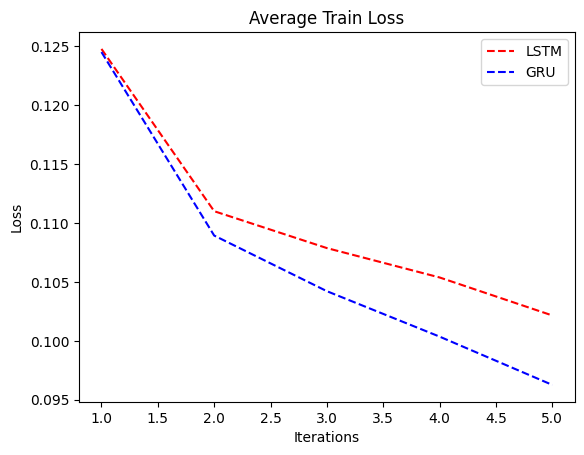

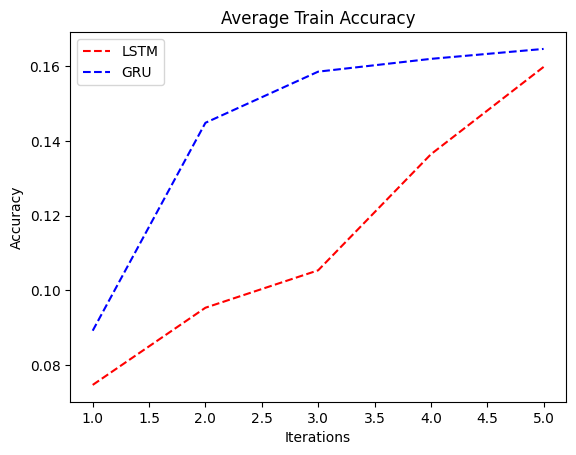

In [23]:
# 导入包
# from feature_extraction import get_batch, Random_Embedding
from torch import optim
import random
import numpy
import torch
# from model import Language
import torch.nn.functional as F
import matplotlib.pyplot
 
 
# 设置随机种子，确保计算的可重复性
random.seed(2024)
numpy.random.seed(2024)
# torch.cuda.manual_seed(2024)
torch.manual_seed(2024)
 
 
# 读取数据
with open('data/poetryFromTang.txt', 'rb') as f:
    # 每行都以字节字符串的形式表示
    temp = f.readlines()
 
 
# 特征提取
a = Random_Embedding(temp)  
a.data_process()    
train = get_batch(a.matrix, 1)  # 训练数据集
learning_rate = 0.004   # 学习率
iter_times = 250  # 训练的迭代次数

 
 
# 计算损失和准确度
strategies = ['LSTM', 'GRU']
train_loss_records = list()  # 记录每个模型的训练损失
train_acc_records = list()  # 记录每个模型的准确率
total_acc_records = list()  # 记录累计的准确率
models = list()
# 循环两次，i分别为0和1，主要为了用LSTM和GRU两种不同的模型进行训练
for i in range(2):
    # 每个模型的训练过程中使用的随机数是相同的
    random.seed(2024)
    numpy.random.seed(2024)
    # torch.cuda.manual_seed(2024)
    # torch.manual_seed(2024)
    torch.manual_seed(2024)
    # 词嵌入维度、词汇表大小、隐藏层维度、标签字典、词典和模型策略
    model = Language(50, len(a.word_dict), 50, a.tag_dict, a.word_dict, strategy=strategies[i])
    # 定义了一个Adam优化器，用于更新模型参数，学习率为learning_rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # 定义了损失函数，使用交叉熵损失
    loss_fun = F.cross_entropy
    train_loss_record = list()  # 记录每次迭代的损失
    train_acc_record = list()  # 记录每次迭代的准确率
    total_acc = 0  # 累计准确率
    model = model.to(device)
    # 循环iter_times次，迭代模型
    for iteration in range(iter_times):
        # 定义了训练损失、累计准确率和一个计数器
        total_loss = 0
        model.train()
        acc = 0
        total_acc = 0
        # 循环遍历训练数据集中的每个批次
        for i, batch in enumerate(train):
            x = batch.to(device)
            # 将输入数据和标签分离：取 x 的所有行和除了最后一列以外的所有列；x 的所有行和从第二列开始的所有列
            # 模型就可以根据前面的词来预测后面的词
            x, y = x[:, :-1], x[:, 1:]
            # 将预测结果张量的第1维和第2维进行转置
            pred = model(x).transpose(1, 2)
            # 将优化器的梯度归零，计算损失并更新总损失，然后反向传播更新梯度并更新模型参数
            optimizer.zero_grad()
            # 计算预测值 pred 和真实值 y 之间的交叉熵损失
            loss = loss_fun(pred, y)
            # 将当前 batch 的损失加到总损失中。其中 (x.shape[1]-1) 是 batch 的序列长度
            total_loss += loss.item()/(x.shape[1]-1)
            # 计算损失相对于模型参数的梯度
            loss.backward()
            # 更新模型参数
            optimizer.step()
            # 将预测值 pred 沿维度 1 取最大值，得到每个时间步的标签
            pred_labels = pred.argmax(dim=1)
            # 计算准确率
            acc += pred_labels.eq(y).sum().item()
            # 将当前 batch 的样本数量加到累计准确率 total_acc 中
            total_acc += y.numel()
        # 将本次迭代的平均损失加入到训练损失列表中
        train_loss_record.append(total_loss/len(train))
        train_acc = acc / total_acc  # 计算每次迭代的准确率
        train_acc_record.append(train_acc)
        total_acc_records.append(total_acc)  # 记录累计准确率
        print("---------- Iteration", iteration + 1, "----------")
        print("Train loss:", total_loss/len(train))
        print("Train accuracy:", train_acc)
    train_loss_records.append(train_loss_record)
    train_acc_records.append(train_acc_record)  # 记录每个模型的训练准确率
    models.append(model)
 
 
# 通过调用模型的方法生成不同类型的诗歌
"""拼接诗句"""
def cat_poem(l):
    poem = list()
    for item in l:
        poem.append(''.join(item))
    return poem
 
 
""" 生成固定诗句 """
model = models[0]
# 生成一个每句9个字，共有6句的固定格式诗句
poem = cat_poem(model.generate_random_poem(9, 6, random=False))
for sent in poem:
    print("生成固定诗句:",sent)
 
 
""" 生成随机诗句 """
torch.manual_seed(2024)
# 生成一个每句15个字，共有4句的固定格式诗句
poem = cat_poem(model.generate_random_poem(15, 4, random=True))
for sent in poem:
    print("生成随机诗句:",sent)
 
""" 生成固定藏头诗 """
# 生成一个由 4 句，每句长度不超过 20 个字符的固定格式藏头诗
poem = cat_poem(model.generate_hidden_head("春夏秋冬", max_len=20, random=False))
for sent in poem:
    print("生成固定藏头诗:",sent)
 
""" 生成随机藏头诗 """
torch.manual_seed(0)
poem = cat_poem(model.generate_hidden_head("春夏秋冬", max_len=20, random=True))
for sent in poem:
    print("生成随机藏头诗:",sent)
 
 
# 绘制训练损失图
x = list(range(1, iter_times + 1))
matplotlib.pyplot.plot(x, train_loss_records[0], 'r--', label='LSTM')
matplotlib.pyplot.plot(x, train_loss_records[1], 'b--', label='GRU')
matplotlib.pyplot.legend()
matplotlib.pyplot.title("Average Train Loss")
matplotlib.pyplot.xlabel("Iterations")
matplotlib.pyplot.ylabel("Loss")
matplotlib.pyplot.savefig('loss.jpg')
matplotlib.pyplot.show()
 
 
# 绘制准确度图
matplotlib.pyplot.plot(x, train_acc_records[0], 'r--', label='LSTM')
matplotlib.pyplot.plot(x, train_acc_records[1], 'b--', label='GRU')
matplotlib.pyplot.legend()
matplotlib.pyplot.title("Average Train Accuracy")
matplotlib.pyplot.xlabel("Iterations")
matplotlib.pyplot.ylabel("Accuracy")
matplotlib.pyplot.savefig('accuracy.jpg')
matplotlib.pyplot.show()